## Data Lab: Drowsiness Detection

> **Scenario:** According to the National Highway Traffic Safety Administration, every year about 100,000 police-reported crashes involve drowsy driving. These crashes result in more than 1,550 fatalities and 71,000 injuries. Detecting a fatigued driver is therefore vital equipment in modern vehicles. If you don't have the money for an such a vehicle, a DIY solution with Python might be the appropriate answer ;)

For structure and guidance, we apply the [(CRISP-DM)](https://s2.smu.edu/~mhd/8331f03/crisp.pdf) model. This iterative process model consisting of 6 phases shows the individual work steps of a data mining / machine learning project that are typically run through. 

<img src="crisp.png" alt="crisp-dm" style="display:block;margin-left:auto;margin-right:auto;width:25%"> 

A detailed description of each phase can be found in the original article by [(Chapman 1999 et al.)](https://the-modeling-agency.com/crisp-dm.pdf).

For the training data we will use the real-life drowsiness video dataset provided by the University of Texas [(UTA)](https://sites.google.com/view/utarldd/home). These data are free to use for scientific or educational purposes and identities cannot be inferred based on these data only.

For our detection system, 240 frames per video per fatigue condition were extracted and stored from 18 individuals. Most videos of them have a resolution of 1920 x 1080. We tested 3 different approaches for real-time detectection of drowsiness:

1. **K-Nearest Neighbour Classifier:** at this approach, we first have to create and normalize some features before we can apply the classifier.
2. **CNN:** here we have to capture and save single frames from the video files. Afterwards we need to define our network architecture.
3. **Greedy Approach:** probably the most simple one. We just measure the eye aspect ratio and decide the drowsiness based on a predefined threshold value.

But before we get to the classifiers, let's first take a look at the data.
> **Note:** A conda environment with all necessary packages is in the repository. Just import `drowsiness_env.yaml` into your Anaconda environment.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
from drowsiness_imports import *

### 1. Data Understanding

First, an understanding of the available data should be acquired. UTA already provides some insights in this regard, so that a detailed explorative data analysis can be dispensed with.First, an understanding of the available data should be acquired. UTA already provides some insights in this regard, so that a detailed explorative data analysis can be dispensed with.
>__Background of the data__: the UTA dataset consists of 180 RGB videos of 60 unique participants. Each video is around 10 minutes long, and is labeled as belonging to one of three classes: alert (labeled as 0), low vigilant (labeled as 5) and drowsy (labeled as 10). The labels were provided by the participants themselves, based on their predominant state while recording each video. This type of labeling takes into account and emphasizes the transition from alertness to drowsiness. Each set of videos was recorded by a personal cell phone or web camera resulting in various video resolutions and qualities which is in fact a data quality problem. The 60 subjects were randomly divided into five folds of 12 participants, for the purpose of cross validation. 

The dataset has a total size of 111.3 Gigabytes. Be sure to have enough free disk space if you want to download them all. Obvisouly, we can not provide you the stored videos or images so that you need to download them by yourself. However, the file servers are rather bad and relatively slow which often leads to disconnections. A download manager (e.g. [JDownloader](https://jdownloader.org/)) is recommended for the download process.

(1920, 1080, 3)


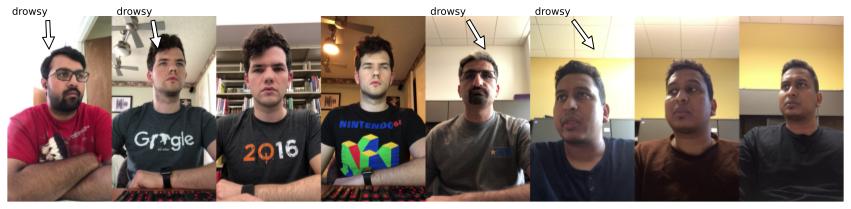

In [8]:
# Depict some images from source videos
flag = True
t = []
for j in np.arange(1, 7):
    for i in np.arange(0, 11, 5):
        vidcap = cv2.VideoCapture(r'G:\Videos\Neuer Ordner\Fold1_part1\\'+str(j)+'\\'+str(i)+'.mov')
        vidcap.set(cv2.CAP_PROP_POS_MSEC, 20000)      
        success, image = vidcap.read()
        if flag:
            print(image.shape)
        if success:
            image = imutils.resize(image, width=450)
            if flag:
                flag = False
                img = image
                t.append(i)
                break
            if (image[:,0,0].shape[0] >= img[:,0,0].shape[0]):
                img = cv2.hconcat([img, image])
                t.append(i)
        
plt.figure(figsize=(15,10))
plt.axis("off")
[plt.annotate('drowsy', xy=(470 * i + 180, 150), xytext=(450 * i + 20, -5), 
              arrowprops=dict(facecolor='white', shrink=0.05)) for i in np.arange(0, len(t) - 1) if t[i] == 0]
plt.imshow(img[:,:,::-1])

>We can see that some images were rated as drowsy by the participants, while other images show a different state of the participants. Intuitively, we would also classify the picture of the gentleman with the N64 T-shirt as drowsy.However, the participant was vigilant here.

### 2. Data Preparation
The Data Preparation phase includes all activities to create the final data set or data selection that will be loaded into the machine learning model for our classification.The Data Preparation phase includes all activities to create the final data set or data selection that will be loaded into the machine learning model for our classification. This means that we first have to generate new data for the KNN classifier by feature engineering. We also need to make a selection of the data. Since we cannot use all frames of the videos, it makes sense, for example, to extract only a specific range of frames of each video.

#### 2.1 Predefined Functions
Core idea is to use some mathematical measures to have a solid indicator when someone is drowsy. These might be used to create features for classifiers. In particular, following concepts might support the detection:

* If someone is drowsy, then his eyes gets smaller or/and are likely to blink more often. We might capture this change and recognize a closing or blinking of eyes with the *Eye Aspect Ratio (EAR)* formula. 

<img src="img0.png" alt="test" style="display:block;margin-left:auto;margin-right:auto;width:20%">  $$ EAR = \frac{||p_2 - p_6||+||p_3 - p_5||}{2 * ||p_1 - p_4||}$$ </img>

* Since we also have the full faces in the dataset we can capture the ratio of mouth length vs width of the mouth. A corresonding measure would be the *Mouth Aspect Ratio (MAR)* formula.

<img src="Mouth-aspect-ratio-MAR.jpg" alt="test" style="display:block;margin-left:auto;margin-right:auto;width:20%"> 

$$MAR = \frac{|EF|}{|AB|}$$

* A further indicator and probably more accurate indicator may be the *Pupil Circularity (PUC)*. In a sense, it extends the EAR formula, but instead of looking at the whole eye, only the changing pupil is considered.

$$ PUC = \frac{4 * \pi * Area}{perimeter^2}, \;\;\;\;\;\; Area = (\frac{Distance(p2, p5)}{2})^2 * \pi $$

* Another indicator can be created from the ratio of MAR divided by EAR and results in the *Mouth aspect ratio over Eye aspect ratio (MOE)*.

$$ MOE = \frac{MAR}{EAR} $$

In [2]:
from drowsiness_functions import *

#### 2.2 Extract features

In [32]:
# Extracting 1 FPS in each video starting at 3 minute mark (skip beginning)
def frame_extraction(folder = "Fold5_part2", participants = [55, 60], MAX_FRAMES = 240):
    def getFrame(sec):
        """Capture frames from video at predefined starting point"""
        start = 180000
        vidcap.set(cv2.CAP_PROP_POS_MSEC, start + sec*1000)
        hasFrames, image = vidcap.read()
        if hasFrames:
            if not (os.path.exists(r"img\\" + str(participant) + "\\")):
                os.mkdir(r"img\\" + str(participant))
            cv2.imwrite(r"img\\" + str(participant) + "\\p" + str(participant) + "_s" + str(state) +
                        "_" + str(count) + "sec.jpg", image)     # save frame
        return hasFrames, image

    participant, state = 0, 0
    # Loop through all videos in a specific folder. Best results with .mov files.
    for j in participants:
        for i in np.arange(0, 11, 5):
            # using video capture class from OpenCV
            clear_output(wait=True) #flush
            print(f'Starting with participant {j} and state {i}')
            data = []
            labels = []
            # drive where the UTA videos are located
            vidcap = cv2.VideoCapture(r'G:\\Videos\\Neuer Ordner\\' + str(folder) + '\\' + str(j) +'\\' + str(i) + '.mov')
            print(f"Total Frames in selected Video {int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))}")
            sec = 0
            frameRate = 1
            count = 0
            success, image  = getFrame(sec)
            participant = j
            state = i
            # Extract frames (per video), the more frames the longer the extraction takes
            while success and count < MAX_FRAMES: 
                landmarks = extract_face_landmarks(image)
                if landmarks is not None and sum(sum(landmarks)) != 0:
                    count += 1
                    data.append(landmarks)
                    labels.append([i])
                    sec = sec + frameRate
                    sec = round(sec, 2)
                    success, image = getFrame(sec)
                    print(count)
                else:  
                    sec = sec + frameRate
                    sec = round(sec, 2)
                    success, image = getFrame(sec)
                    print("not detected")
            if success:
                data = np.array(data)
                labels = np.array(labels)
                print(f"Data {data.shape}")
                print(f"Labels {labels.shape}")
                features = []
                for d in data:
                    # extract relevant facial landmarks from OpenCV
                    eye = d[36:68]
                    # here we create our features for our base classifier
                    ear = eye_aspect_ratio(eye)
                    mar = mouth_aspect_ratio(eye)
                    cir = circularity(eye)
                    mouth_eye = mouth_over_eye(eye)
                    features.append([int(participant), ear, mar, cir, mouth_eye])
                features = np.array(features)
                print(f"Features {features.shape}")
                # save captured data as csv files with numpy for backup reasons
                np.savetxt('data_drowsiness\\' + str(folder) +'_features_'+str(participant)+'_'+str(state)+'.csv', features, delimiter = ",")
                np.savetxt('data_drowsiness\\' + str(folder) +'_labels_'+str(participant)+'_'+str(state)+'.csv', labels, delimiter = ",")

In [7]:
%%time
# x = folder containing individual participant subfolders containing videos
x = os.listdir('G:\\Videos\\Neuer Ordner\\')
for i,j in zip(x, [os.listdir('G:\\Videos\\Neuer Ordner\\'+i) for i in x]):
    frame_extraction(folder=i, participants=j)
pd.read_csv(r"data_drowsiness\Fold5_part2_features_60_5.csv", header=None, names=["Participant", "EAR", "MAR", "Circularity", "MOE"])

Wall time: 0 ns


In [4]:
# Read in all feature files and merge them to one
df_features = [pd.read_csv(f, header=None, names=["Participant", "EAR", "MAR", "Circularity", "MOE"]) for f in glob.glob("data_drowsiness\Fold*_features_*.csv")]
df_labels = [pd.read_csv(f, header=None, names=["Y"]) for f in glob.glob("data_drowsiness\Fold*_labels_*.csv")]

df = pd.concat([pd.concat(df_features,ignore_index=True), pd.concat(df_labels,ignore_index=True)], axis=1)
print(df.shape) 
# Save merged file
df.to_csv(r'data_drowsiness\merged\totalwithrespondent.csv',index=False)
df.head()

(12960, 6)


,Participant,EAR,MAR,Circularity,MOE,Y
0,1.0,0.312688,0.792397,0.432896,2.534145,0.0
1,1.0,0.321940,0.766199,0.486923,2.379947,0.0
2,1.0,0.331216,0.688449,0.456029,2.078550,0.0
3,1.0,0.309246,0.776136,0.452655,2.509767,0.0
4,1.0,0.204691,0.734189,0.361123,3.586821,0.0


#### 2.3 Standardization

The data standardization is the process of rescaling one or more attributes so that they have a mean value of 0 and a standard deviation of 1. This is often performed on classification tasks where the data has more the shape of a gaussian distribution which finally leads to an improvement of the model accuracy. 
$$ z = \frac{x_i - \mu}{\sigma}$$
>**Note:** If we have different scale units we should apply standardization and if we expect *significant* differences in the value ranges we should apply normalization. 

In [5]:
#Reading the CSV back into a dataframe
df_total = pd.read_csv(r'data_drowsiness\merged\totalwithrespondent.csv')

#Reordering the columns
cols = df_total.columns.tolist()
cols = cols[-1:] + cols[4:5] + cols[:4]
df_total = df_total[cols]
df_total

,Y,MOE,Participant,EAR,MAR,Circularity
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123
...,...,...,...,...,...,...
12955,5.0,3.011821,60.0,0.348480,1.049561,0.490477
12956,5.0,4.016572,60.0,0.262352,1.053755,0.395392
12957,5.0,3.212684,60.0,0.319431,1.026230,0.490811
12958,5.0,4.230846,60.0,0.256146,1.083715,0.378786


In [6]:
# Check if a candidate has only 5.0 labeled data
t = df_total.drop_duplicates("Participant")
df_total = df_total[~df_total.Participant.isin(t[t.Y > 0].Participant)]
df_total.shape

(12720, 6)

In [7]:
from drowsiness_standardisation import Standardization
pd.options.mode.chained_assignment = None
#Standardization
df_total = Standardization(df_total).calculate_Standardization()
df_total.head()

(12720, 14)


,Y,MOE,Participant,EAR,MAR,Circularity,EAR_mean,MAR_mean,Circularity_mean,MOE_mean,EAR_std,MAR_std,Circularity_std,MOE_std,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,1.0,0.312688,0.792397,0.432896,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,1.0,0.321940,0.766199,0.486923,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,1.0,0.331216,0.688449,0.456029,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,1.0,0.309246,0.776136,0.452655,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,1.0,0.204691,0.734189,0.361123,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-12.657205,-0.274242,-3.596686,5.419921


In [8]:
#Saving the file to a CSV with all the information
df_total.to_csv(r'data_drowsiness\prepared\totalwithallinfo.csv',index=False)
#Saving the file to a CSV with all the information
df_main = df_total.drop(["EAR_mean","MAR_mean", "Circularity_mean", "MOE_mean", "EAR_std", "MAR_std", "Circularity_std", "MOE_std"], axis=1)
df_main.to_csv(r'data_drowsiness\prepared\totalwithmaininfo.csv',index=False)

### 3. Modelling
In this phase, we go through the steps to create a model and feed it with the previously prepared data. Key sub-steps are the model development and definition of the parameters as well as initial evaluation steps. The selection of a suitable model is also a central aspect here.

#### 3.1 KNN-Classifer

Motivated by the article of [Zhong (2019)](https://towardsdatascience.com/drowsiness-detection-with-machine-learning-765a16ca208ahttps://towardsdatascience.com/drowsiness-detection-with-machine-learning-765a16ca208a), the KNN classifier obtained useful results. Therefore, it is worthwhile to apply the classifier again. Maybe we will get a higher accuracy!

In [3]:
# Read in dlibs shape predictor for detecting facial landmarks
p = r"shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [4]:
# read in prepared data
df = pd.read_csv(r'data_drowsiness\prepared\totalwithmaininfo.csv',sep=',')
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)
df = df[df.Y != 5.0]  # form a binary problem, delete the 5.0 ones
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)

train_percentage = 14/18 # based on max uniq. participants
train_samples = int(len(df) * train_percentage)
test_samples = len(df) - train_samples

df_train = df[:train_samples]
df_test = df[-test_samples:]

X_test = df_test.drop(["Y"], axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y', axis=1)
y_train = df_train['Y']
print(f'X_test: {X_test.shape} \ny_test: {y_test.shape} \nX_train: {X_train.shape} \ny_train: {y_train.shape}')
df_train

X_test: (1920, 8) 
y_test: (1920,) 
X_train: (6720, 8) 
y_train: (6720,)


,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
9595,1.0,3.516036,0.308254,1.083833,0.440628,-3.087456,3.700493,-1.776452,4.040717
9596,1.0,3.585545,0.301381,1.080614,0.447949,-3.694883,3.646635,-1.472575,4.322363
9597,1.0,3.750118,0.286855,1.075740,0.450278,-4.978551,3.565087,-1.375905,4.989206
9598,1.0,4.123695,0.260188,1.072936,0.403545,-7.335156,3.518178,-3.315660,6.502924


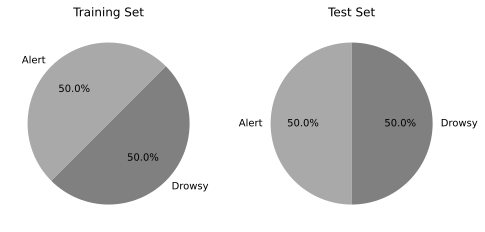

In [5]:
# see label distribution
label = 'Alert', 'Drowsy'
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.title("Training Set")
plt.pie(df_train.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=45, colors={"grey", "darkgrey"})
plt.subplot(122)
plt.title("Test Set")
plt.pie(df_test.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=90, colors={"grey", "darkgrey"})
plt.show()

In [6]:
#KNN classifier
def average(y_pred):
    """Averaging sequential frames for classifier"""
    for i in range(len(y_pred)):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] + y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

acc3_list = []
f1_score3_list = []
roc_3_list = []

# take 45 runs and save best one
for i in range(1, 45):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
print(f"Neighbors: {neigh.get_params()['n_neighbors']}")
neigh.fit(X_train, y_train) 

Neighbors: 38


KNeighborsClassifier(n_neighbors=38)

In [7]:
def model_knn(landmarks):
    """Returns features and classification result"""
    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])
    eye = landmarks[36:68] # Extracting relevant parts (eyes + mouth)
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)
    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)

    # Normalisation
    df["EAR_N"] = (df["EAR"] - mean["EAR"]) / std["EAR"]
    df["MAR_N"] = (df["MAR"] - mean["MAR"]) / std["MAR"]
    df["Circularity_N"] = (df["Circularity"] - mean["Circularity"]) / std["Circularity"]
    df["MOE_N"] = (df["MOE"] - mean["MOE"]) / std["MOE"]
    
    Result = neigh.predict(df)  
    if Result == 1:
        Result_String = "Drowsy"
        fontColor = (0, 0, 245)
    else:
        Result_String = "Alert"
        fontColor = (255, 255, 255)
    
    return Result_String, df.values, fontColor

#### 3.2 CNN
We can use the extracted frames to build a convolutional neural network for the binary classification problem. The planned network consists of 2 convolutional layers with a dropout of 30% and two linear layers. Since we are doing binary classification, the ReLu activation function is suitable. As pooling function we use a simple 2D-MaxPool function for the output of the convolutions.

In [22]:
# agnostic cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [25]:
# Create a folder for training and test images and copy the extracted images into it
# Used schema: <source>img\\{item} <destination>cnn_train\\{item}
copy_imgs(train_set = False, participants) #if set to false, then the test set is copied

SyntaxError: positional argument follows keyword argument (<ipython-input-25-7a9d3c3d412d>, line 3)

In [26]:
# Image transformations and data loaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_img = transforms.Compose([transforms.Resize((224, 224)),
                                  # transforms.CenterCrop(256),
                                    transforms.ToTensor(),
                                    normalize])

train_data = torchvision.datasets.ImageFolder(r"cnn_train", transform=transform_img)
validation_data = torchvision.datasets.ImageFolder(r"cnn_test", transform=transform_img)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0) #shuffle is here recommendable
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False, num_workers=0)
print(train_data, validation_data)

traningimages, labels = next(iter(train_loader))
labels.shape

Dataset ImageFolder
    Number of datapoints: 7226
    Root location: cnn_train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 1440
    Root location: cnn_test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


torch.Size([32])

training images
torch.Size([3, 224, 224])


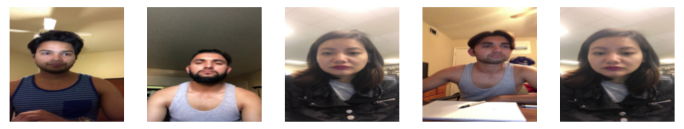

In [8]:
# show 5 resized images from a batch as torch images
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0)) #reshape to width,height,channel

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=True)

print(trainimages[0].size())

In [28]:
# CNN Classifier
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(58320, 1024) 
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))     #relu activation after max pool
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)  #reshape tensor
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=58320, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [36]:
model = CNN().to(device) # give it to cuda (if available)
# hyperparameters
learning_rate = 10e-4
num_epochs = 9 #35
criterion = nn.CrossEntropyLoss() #log loss function
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # define gradient optimizer

In [37]:
%%time
# keeping-track-of-losses 
train_losses, valid_losses, train_accuracies = [], [], []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss, valid_loss, correct = 0.0, 0.0, 0.0

    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform single optimization-step (parameter-update)
        optimizer.step()
        # calculate acc
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        # update training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)
    accuracy = 100 * correct / len(train_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(accuracy)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(epoch, train_loss, valid_loss, accuracy))

Epoch: 1 	Training Loss: 0.171499 	Validation Loss: 0.004857 	Accuracy: 97.204539
Epoch: 2 	Training Loss: 0.017998 	Validation Loss: 0.002004 	Accuracy: 99.778577
Epoch: 3 	Training Loss: 0.019002 	Validation Loss: 0.000132 	Accuracy: 99.820094
Epoch: 4 	Training Loss: 0.015998 	Validation Loss: 0.000711 	Accuracy: 99.820094
Epoch: 5 	Training Loss: 0.014430 	Validation Loss: 0.001078 	Accuracy: 99.820094
Epoch: 6 	Training Loss: 0.013551 	Validation Loss: 0.003078 	Accuracy: 99.847772
Epoch: 7 	Training Loss: 0.012438 	Validation Loss: 0.003551 	Accuracy: 99.861611
Epoch: 8 	Training Loss: 0.008871 	Validation Loss: 0.000774 	Accuracy: 99.847772
Epoch: 9 	Training Loss: 0.012042 	Validation Loss: 0.002783 	Accuracy: 99.903128
Wall time: 46min 33s


In [38]:
%%time
# Save model
torch.save(model, "cnn_drowsiness.pt")
## Save parameters only
torch.save(model.state_dict(), "cnn_drowsiness.pth")

# Load
model = CNN().to(device)
model.load_state_dict(torch.load("cnn_drowsiness.pth"))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Load entire model
model = torch.load("cnn_drowsiness.pt")

Model's state_dict:
conv1.weight 	 torch.Size([10, 3, 3, 3])
conv1.bias 	 torch.Size([10])
conv2.weight 	 torch.Size([20, 10, 3, 3])
conv2.bias 	 torch.Size([20])
fc1.weight 	 torch.Size([1024, 58320])
fc1.bias 	 torch.Size([1024])
fc2.weight 	 torch.Size([2, 1024])
fc2.bias 	 torch.Size([2])
Wall time: 2.98 s


tensor([[ 0.4767, -0.4530]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0], device='cuda:0')


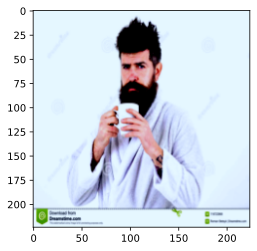

In [39]:
# Loading and Testing a single img on the CNN classifier
img_path=r"awake.jpg" #tired.jpg
image = Image.open(img_path)
transform_img = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image = transform_img(image) #apply same transformation steps
image = image.unsqueeze(0) # adding batch dim (because we only have 3 dims)

# test mode
model.eval()

with torch.no_grad():
    image = image.to(device)
    # forward propagation
    output = model(image)
    print(output)
    # get prediction
    output = torch.argmax(output, 1)
print(output)

t = np.transpose(image.detach().cpu().numpy().squeeze(), (1, 2, 0))
plt.imshow(np.array([i * 0.4 for i in t]))

In [40]:
def prediction_cnn(image):
    """Returns cnn classification result"""
    # We need to convert opencv into PIL img
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transform_img(image).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = torch.argmax(output, 1)

    Result = output.item()  
    if Result == 1:
        Result_String = "Drowsy"
        fontColor = (0, 0, 245)
    else:
        Result_String = "Alert"
        fontColor = (255, 255, 255)
    
    return Result_String, fontColor

#### 3.3 Live Demo

In [20]:
def live(cnn = False):
    """real-time drowsiness recognition"""
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10, 400)
    fontScale              = 1
    lineType               = 2
    cap = cv2.VideoCapture(0)
    data = []
    result = []
    
    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)

        if not cnn:
             # For each detected face, find the landmark.
            for (i, rect) in enumerate(rects):
                # Make the prediction and transfom it to numpy array
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)
                Result_String, features, fontColor = model_knn(shape) 
                
                cv2.putText(image, Result_String, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
                data.append (features)
                result.append(Result_String)
    
                # Draw on our image, all the finded cordinate points (x,y) 
                for (x, y) in shape:
                    cv2.circle(image, (x, y), 2, (0, 255, 0), -1) # maybe changing red if drowsy, otherwise green
        else:
                # Use CNN model
                Result_String, fontColor = prediction_cnn(image) 
                cv2.putText(image, Result_String, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
                result.append(Result_String)
                
        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(5) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data, result

In [8]:
#Run Calibration
mean, std = calibration(detector, predictor)
for i, j in zip(mean, std):
    print("Mean {:4f} and standard deviation {:4f}".format(i, j))

In [65]:
#Run Demonstration with KNN classifier
features, result = live()

In [29]:
#Run Demonstration with CNN classifier
_, result_cnn = live(True)

### 4. Evaluation
In this step, we will take a closer look at our trained learning models. Often diagrams and visualizations can support the performance evaluation of the models. There are metrics that can evaluate the grade of a trained model. Many times, decision criteria are evaluated at this stage as to when a model is considered good enough for the business. The definition of these criteria should already appear in the business understanding (i.e. phase 0). If there is still room for improvement in the evaluation step, sometimes the backward step to Business Understanding is necessary (as also recommended by CRISP-DM). Anyway, we will only do a rudimentary evaluation here. We look at the score values of the two classification strategies and also show in which frames we were tired during the stream based on the trained models.

#### 4.1 Scores of KNN-Classifier

Text(0.5, 0, 'Time (Frames Captured)')

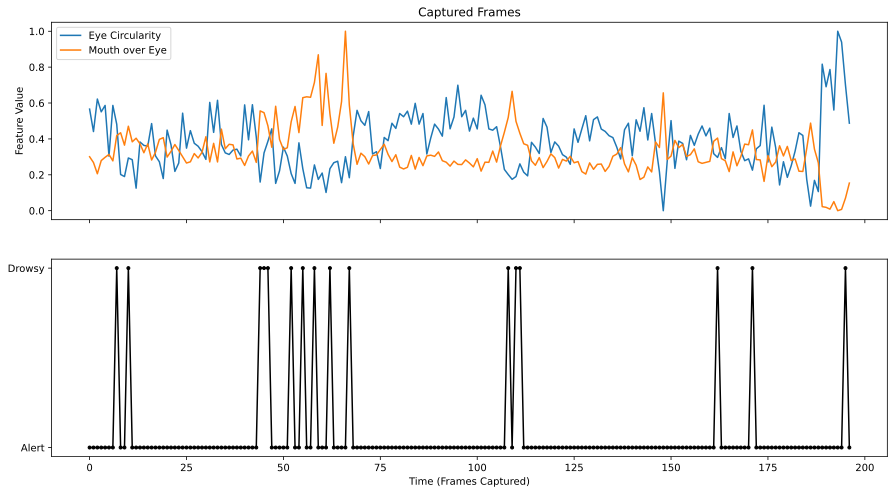

In [55]:
#Plot Results
features =np.vstack(features)
y = pd.DataFrame(features, columns=["EAR","MAR","Circularity","MOE","EAR_N","MAR_N","Circularity_N","MOE_N"])
y = y.drop(columns=["EAR_N","MAR_N","Circularity_N","MOE_N"])

x = y.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = pd.DataFrame(x_scaled, columns=["Eye Aspect Ratio","Mouth Aspect Ratio","Eye Circularity","Mouth over Eye"])

y["Result"] = result

fig, (ax1, ax2) = plt.subplots(nrows=2,
                               ncols=1,
                               sharex=True,
                               sharey=False,
                               figsize=(15, 8))

ax1.set_title("Captured Frames")
ax1.plot(y["Eye Circularity"])
ax1.plot(y["Mouth over Eye"])
ax1.legend(("Eye Circularity", "Mouth over Eye"), loc="best")
ax1.set_ylabel('Feature Value')

ax2.plot(y["Result"],marker = '.', color = "Black")
ax2.set_xlabel('Time (Frames Captured)')

In [16]:
pred_KN = neigh.predict(X_test)
pred_KN = average(pred_KN)
y_score_3 = neigh.predict_proba(X_test)[:,1]
acc3 = accuracy_score(y_test, pred_KN)
f1_score_3 = metrics.f1_score(y_test, pred_KN)
roc_3 = metrics.roc_auc_score(y_test, y_score_3)
print("Accuracy: {:3f} \nF1-Score: {:3f} \nROC: {:3f}".format(acc3, f1_score_3, roc_3))
print(confusion_matrix(y_test, pred_KN))
print(f"Correct classified items {np.trace(confusion_matrix(y_test, pred_KN))} based on {y_test.shape[0]} test records")

Accuracy: 0.702604 
F1-Score: 0.636999 
ROC: 0.748062
[[848 112]
 [459 501]]
Correct classified items 1349 based on 1920 test records


#### 4.2 Scores of CNN

Test Accuracy of the model: 100.000000 %
Correct classified items 1440
Total items 1440


CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=58320, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

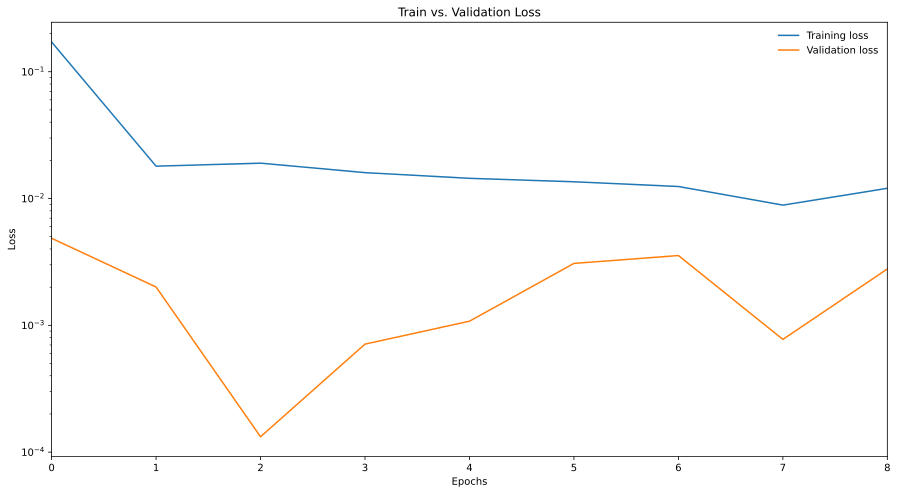

In [42]:
# test-the-model
model.eval()  # it disables dropout layers and put the model in evaluation mode
with torch.no_grad():  # turn off gradient calculation to improve speed and reduce memory consumption (it automatically turns on after block)
    correct = 0
    total = 0
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {:6f} %'.format(100 * correct / total))
    print("Correct classified items", correct)
    print("Total items", total)
    
plt.figure(figsize=(15, 8))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.yscale("log")
plt.xlim([0, num_epochs - 1])
plt.legend(frameon=False)

# Turn back in train mode
model.train()

### The Greedy Approach
We had observed some degree of overfitting in both classifiers, which can be explained by the low variance in the UTA data. Although the amount of data is sufficiently high (over 12,000 images), more different shots in different seating positions, illuminations would have been better for the models. Even though our CNN with apparently 100% accuracy seems convincing at first, it is also overfitted. It classifies the whole image correctly when we rest our head on the table, for example. However, it becomes problematic if we change the lighting during our live recording, if we constantly change our position or if there are objects between our face and the camera. This often leads to wrong classifications. A decent and rather convenient way is therefore the way over a predefined threshold value, where in any case an alarm signal sounds when this value is exceeded. This solution does not require any drowsiness training data at all.

In [34]:
# Using only a threshold value for detecting drowsiness
EYE_THRESH = 0.25  #indicate for blink
EYE_FRAMES = 40  #minimum of consecutive frames of blinking
FRAME_COUNTER = 0
ALARM_ON = False
states = []
ear_results = []

# Load facial landmark predictor from dlib
p = r"shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

# start video stream with openCV
print("Starting video stream thread...")
cap = cv2.VideoCapture(0)
while True:
    # Getting out image by webcam 
    _, image = cap.read()
    image = imutils.resize(image, width=450)
    # Convert img to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscaled frame
    rects = detector(gray, 0)
    
    #loop through array
    for rect in rects:
        # get facial landmarks for the face region and convert to np array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        # build features 
        eye = shape[36:68] # Extracting relevant parts (eyes to mouth)
        # calculate ear
        ear = eye_aspect_ratio(eye)
        # visualize contours only of the eyes
        leftEye  = shape[42:48]
        rightEye = shape[36:42]
        cv2.drawContours(image, [cv2.convexHull(leftEye)], -1, (0, 255, 0), 1)
        cv2.drawContours(image, [cv2.convexHull(rightEye)], -1, (0, 255, 0), 1)
        
        #check if ear is below defined threshold
        if ear < EYE_THRESH:
            FRAME_COUNTER += 1
            if FRAME_COUNTER >= EYE_FRAMES:
                if not ALARM_ON:
                    ALARM_ON = True
                    t = Thread(target=sound_alarm(path="alarm.wav"))
                    t.deamon = True
                    t.start()
                cv2.putText(image, "Drowsiness detected!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                ear_results.append(ear)
                states.append("drowsy")
                #cv2.putText(image, Result_String, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
        else:
            FRAME_COUNTER = 0
            ear_results.append(ear)
            states.append("alert")
            ALARM_ON = False
        
        #draw EAR
        cv2.putText(image, "EAR: {:3f}".format(ear), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
    # Show the image
    cv2.imshow("Output", image)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

cv2.destroyAllWindows()
cap.release()

Starting video stream thread...


Text(0.5, 0, 'Time (Frames Captured)')

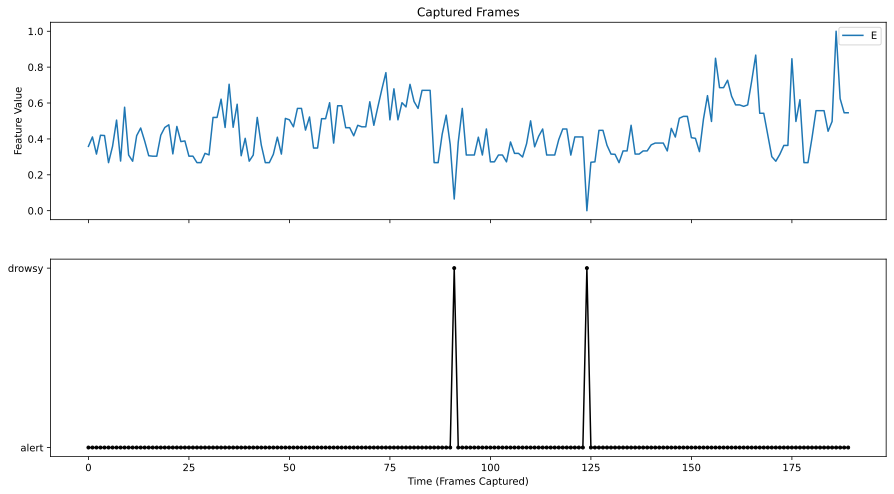

In [59]:
#Plot Results
y = pd.DataFrame(ear_results, columns=["EAR"])
x = y.values
x_scaled = preprocessing.MinMaxScaler().fit_transform(x)
y = pd.DataFrame(x_scaled, columns=["EAR"])
y["Result"] = states

fig, (ax1, ax2) = plt.subplots(nrows=2,
                               ncols=1,
                               sharex=True,
                               sharey=False,
                               figsize=(15, 8))

ax1.set_title("Captured Frames")
ax1.plot(y["EAR"])
ax1.legend(("EAR"), loc="best")
ax1.set_ylabel('Feature Value')

ax2.plot(y["Result"], marker = '.', color = "Black")
ax2.set_xlabel('Time (Frames Captured)')

### 5. Deployment
In this final step, the model is integrated into an existing environment and goes live. From here on, the model becomes part of the value chain (since, as a rule, such projects should also add economic value). A final report or documentation and a plan for any updates complete the phase. It is important to understand that even after the deployment phase, the solution may be complete in isolation, but over time new problems arise that require new solutions. In the case of the Live Detection System, this could be placed in weaker vehicles via a [Raspberry PI](https://www.raspberrypi.org/products/raspberry-pi-4-model-b/) or [Jetson Nano](https://www.nvidia.com/de-de/autonomous-machines/embedded-systems/jetson-nano/education-projects/).